# Table of Contents
 <p><div class="lev1 toc-item"><a href="#The-algorithm-to-optimize" data-toc-modified-id="The-algorithm-to-optimize-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The algorithm to optimize</a></div><div class="lev1 toc-item"><a href="#-Create-grid" data-toc-modified-id="-Create-grid-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><i class="fa fa-slack"></i> Create grid</a></div><div class="lev1 toc-item"><a href="#-Contour-map" data-toc-modified-id="-Contour-map-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><i class="fa fa-line-chart"></i> Contour map</a></div><div class="lev1 toc-item"><a href="#Normal-optimization" data-toc-modified-id="Normal-optimization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Normal optimization</a></div><div class="lev1 toc-item"><a href="#Bayesian-optimization" data-toc-modified-id="Bayesian-optimization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bayesian optimization</a></div><div class="lev2 toc-item"><a href="#-Parameter-file" data-toc-modified-id="-Parameter-file-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span><i class="fa fa-file"></i> Parameter file</a></div><div class="lev2 toc-item"><a href="#-Scenario-file" data-toc-modified-id="-Scenario-file-52"><span class="toc-item-num">5.2&nbsp;&nbsp;</span><i class="fa fa-file"></i> Scenario file</a></div><div class="lev1 toc-item"><a href="#Call-SMAC!" data-toc-modified-id="Call-SMAC!-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Call SMAC!</a></div><div class="lev2 toc-item"><a href="#Sequential-Model-based-Algorithm-Configuration" data-toc-modified-id="Sequential-Model-based-Algorithm-Configuration-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Sequential Model-based Algorithm Configuration</a></div><div class="lev1 toc-item"><a href="#Read-outputs" data-toc-modified-id="Read-outputs-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Read outputs</a></div><div class="lev1 toc-item"><a href="#Compare" data-toc-modified-id="Compare-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Compare</a></div><div class="lev1 toc-item"><a href="#Categorical" data-toc-modified-id="Categorical-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Categorical</a></div><div class="lev1 toc-item"><a href="#Ordinal" data-toc-modified-id="Ordinal-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Ordinal</a></div>

In [7]:
# scientific python
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math
#awesome plot options
plt.style.use('fivethirtyeight')
sns.set(style="white")
%matplotlib inline
#image stuff
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['savefig.dpi'] = 100
from matplotlib.colors import LogNorm
#%config InlineBackend.figure_format='retina'

# The algorithm to optimize

In [2]:
!head -n 50 example_scenarios/branin/branin.py

#!/usr/bin/python
import sys, math, random

# For black box function optimization, we can ignore the first 5 arguments. 
# The remaining arguments specify parameters using this format: -name value 

x1 = 0 
x2 = 0

for i in range(len(sys.argv)-1):  
    if (sys.argv[i] == '-x1'):
        x1 = float(sys.argv[i+1])
    elif(sys.argv[i] == '-x2'):
        x2 = float(sys.argv[i+1])   
 
# Compute the branin function:
yValue = (x2 - (5.1 / (4 * math.pi * math.pi)) *x1*x1 + (5 / (math.pi)) *x1 -6) ** 2 + 10*(1- (1 / (8 * math.pi))) * math.cos(x1) + 10




  
# SMAC has a few different output fields; here, we only need the 4th output:
print "Result of algorithm run: SUCCESS, 0, 0, %f, 0" % yValue
 


 $$ f(x,y) = \left(y - \frac{5.1}{4 \pi^2} x^2 + \frac{5}{\pi}x -6 \right)^2 + 10 \left (1 - \frac{1}{8 \pi} \right ) cos(x)+10 $$

In [3]:
def branin(x):
    x1 = x[0]
    x2 = x[1]
    yValue = (x2 - (5.1 / (4 * math.pi * math.pi)) *x1*x1 + (5 / (math.pi)) *x1 -6) ** 2 + 10*(1- (1 / (8 * math.pi))) * math.cos(x1) + 10
    return yValue

# <i class="fa fa-slack"></i> Create grid

In [4]:
X = np.linspace(-5, 10, 500 )
Y = np.linspace(0, 15, 500 )

Z = np.zeros((X.shape[0],Y.shape[0]))
for ix,x in enumerate(X):
    for iy,y in enumerate(Y):
        Z[ix,iy] = branin([x,y])

minZ=np.min(Z)

for ix,x in enumerate(X):
    for iy,y in enumerate(Y):
        if minZ == Z[ix,iy]:
            locminZ=[x,y]
X, Y = np.meshgrid(X, Y)
print("minima %f at %s "%(minZ,str(locminZ)))

minima 0.398029 at [-3.1362725450901805, 12.264529058116231] 


# <i class="fa fa-line-chart"></i> Contour map

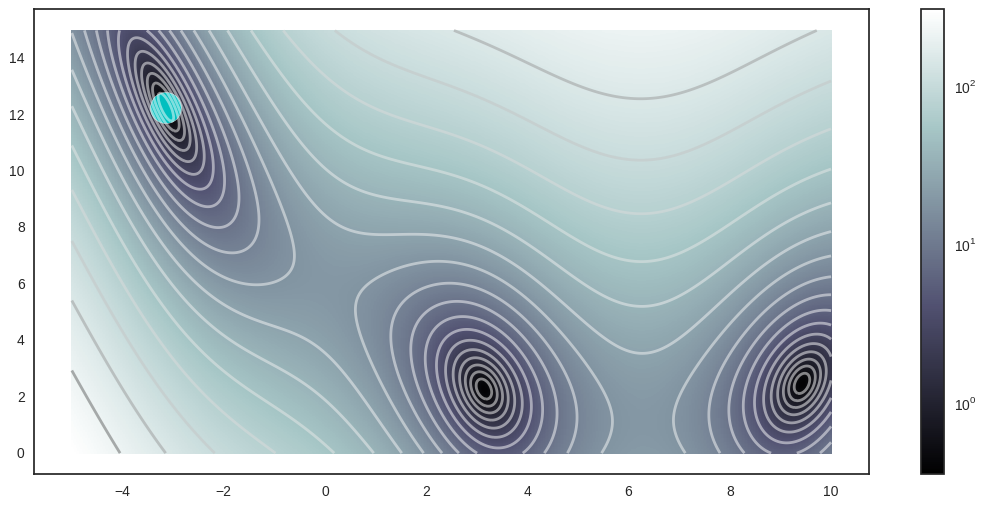

In [8]:
plt.pcolor(X,Y,Z.T,
           norm=LogNorm(vmin=np.min(Z)*0.9,vmax=np.max(Z)),
          cmap='bone')
plt.colorbar()
levels = np.logspace(np.log10(np.min(Z)*0.9), np.log10(np.max(Z)), 20)
plt.contour(Z.T, levels,linewidths=2,alpha=0.5,extent=(-5,10,0,15))
plt.scatter(locminZ[0],locminZ[1],s=500,c='c',label='Grid')
plt.show()

# Normal optimization

In [1]:
from scipy.optimize import minimize
guess = (2.5,7.5)
pos =[]
def info(x):
    pos.append(x)
    
methods = ['BFGS','CG','Nelder-Mead']
for method in methods:
    res = minimize(branin, guess, jac=False, method=method,callback=info,options={ 'disp': True})
    pos=np.array(pos)

    print("%s, success? %s "%(method,res['success']))
    if res['success']:
        print("minima %f at %s "%(branin(res['x']),str(res['x'])))


NameError: name 'branin' is not defined

Optimization terminated successfully.
         Current function value: 0.397887
         Iterations: 41
         Function evaluations: 80
minima 0.397887 at [ 3.14157157  2.27501556] 


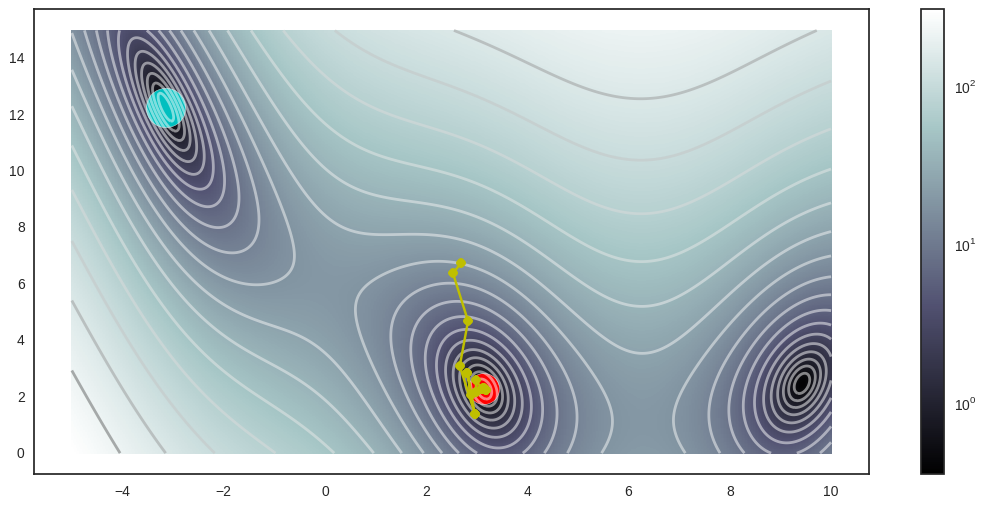

In [11]:
pos =[]
def info(x):
    pos.append(x)
    
res = minimize(branin, guess, jac=False, method='Nelder-Mead',callback=info,options={ 'disp': True})
pos=np.array(pos)
print("minima %f at %s "%(branin(res['x']),str(res['x'])))

plt.pcolor(X,Y,Z.T,
           norm=LogNorm(vmin=np.min(Z)*0.9,vmax=np.max(Z)),
          cmap='bone')
plt.colorbar()
levels = np.logspace(np.log10(np.min(Z)*0.9), np.log10(np.max(Z)), 20)
plt.contour(Z.T, levels,linewidths=2,alpha=0.5,extent=(-5,10,0,15))
plt.scatter(locminZ[0],locminZ[1],s=800,c='c',label='Grid')
plt.plot(pos[:,0],pos[:,1],'-o',c='y')
plt.scatter(res['x'][0],res['x'][1],s=500,c='r',label='Grid')
plt.show()

# Bayesian optimization

Ingredients for running smac:

* Scenario file (.txt)
* Function file  (.py)
* Parameter file (.pcs)

## <i class="fa fa-file"></i> Parameter file
Defining variables and range to look for plus inital guess

In [12]:
!head -n 50 example_scenarios/branin/params.pcs

x1 real [-5,10] [2.5]
x2 real [0,15]  [7.5]

## <i class="fa fa-file"></i> Scenario file

In [13]:
!head -n 50 example_scenarios/branin/branin-scenario.txt

use-instances = false
runObj = QUALITY
numberOfRunsLimit = 500
pcs-file = example_scenarios/branin/params.pcs
algo = example_scenarios/branin/branin.py


# Call SMAC!
## Sequential Model-based Algorithm Configuration

In [14]:
!./smac --scenario-file example_scenarios/branin/branin-scenario.txt --seed 1234

[INFO ] Logging to: /home/beangoben/projects/BayesianOpt/smac-v2.10.03-master-778/smac-output/branin-scenario/log-run1234.txt
[INFO ] Version of SMAC is v2.10.03-master-778 (3ee628ef9bf2), running on OpenJDK 64-Bit Server VM (1.7.0_85) and Linux 3.19.0-31-generic (amd64) 
[INFO ] Call String: smac --scenario-file example_scenarios/branin/branin-scenario.txt --seed 1234 
[INFO ] Found previous run data in state output folder: /home/beangoben/projects/BayesianOpt/smac-v2.10.03-master-778/smac-output/branin-scenario , renamed to: old-state-state-run1234-1446142022248
[INFO ] SMAC started at: Oct 29, 2015 2:07:02 PM. Minimizing mean quality.
[INFO ] First incumbent: config 1 (internal ID: 0x000B), with mean quality: 24.129964; estimate based on 1 runs.
[INFO ] Sample call for new incumbent config 1 (internal ID: 0x000B): 
cd /home/beangoben/projects/BayesianOpt/smac-v2.10.03-master-778; example_scenarios/branin/branin.py no_instance 0 1.7976931348623157E308 2147483647 -1 -x1 '2.5' -x2 '7.5

# Read outputs

In [15]:
import pandas as pd

In [16]:
run_df = pd.read_csv('smac-output/branin-scenario/state-run1234/runs_and_results-it49.csv')
run_df.head(1)

,Run Number,Run History Configuration ID,Instance ID,Response Value (y),Censored?,Cutoff Time Used,Seed,Runtime,Run Length,Run Result Code,Run Quality,SMAC Iteration,SMAC Cumulative Runtime,Run Result,Additional Algorithm Run Data,Wall Clock Time,Unnamed: 16
0,1,1,1,24.129964,0,1.7976931348623157E308,-1,0,0,1,24.129964,0,0,SAT,NaN,0.031,NaN


In [17]:
run_df = pd.read_csv('smac-output/branin-scenario/state-run1234/runs_and_results-it49.csv')
run_df.head(1)
param_df = pd.read_csv('smac-output/branin-scenario/state-run1234/paramstrings-it49.txt',header=0)
extrarow = pd.DataFrame([list(param_df.columns)],columns=list(param_df.columns))
param_df=param_df.set_index(param_df.index+1)
param_df=param_df.append(extrarow)
param_df.sort_index(inplace=True)
param_df.columns = ['x1','x2']
param_df.head(2)
def cleanParamFile(row):

    values = []
    for i in range(row.shape[0]):
        values.append(float(row.iloc[i].split('=')[-1].replace("\'",'')))

    return pd.Series(values)

df = pd.DataFrame(param_df.apply(cleanParamFile,axis=1))
df.columns = ['x1','x2']
df['y']=run_df['Run Quality']
df.head(1)

,x1,x2,y
0,2.5,7.5,24.129964


# Compare

In [20]:
import random
mins=[]
for i in range(100):
    locmin=100
    for j in range(100):
        x1=random.uniform(-5,10)
        x2=random.uniform(0,15)
        locmin= min( [branin([x1,x2]), locmin])
    mins.append(locmin)
mcc_min=np.mean(mins)
    
indx =np.argmin(df['y'])
row = df.iloc[indx]
miny=np.min(df['y'])
rangex1=[ np.min(df['x1']),np.max(df['x1'])]
rangex2=[ np.min(df['x2']),np.max(df['x2'])]

print("MC : minima %f "%(mcc_min))
print("SMAC: minima %f at %s "%(miny,str(row[['x1','x2']].values)))
print("Opt: minima %f at %s "%(np.min(Z),str(locminZ)))

MC : minima 0.954729 
SMAC: minima 0.424976 at [ -3.20144032  12.51877621] 
Opt: minima 0.398056 at [-3.1362725450901805, 12.264529058116231] 


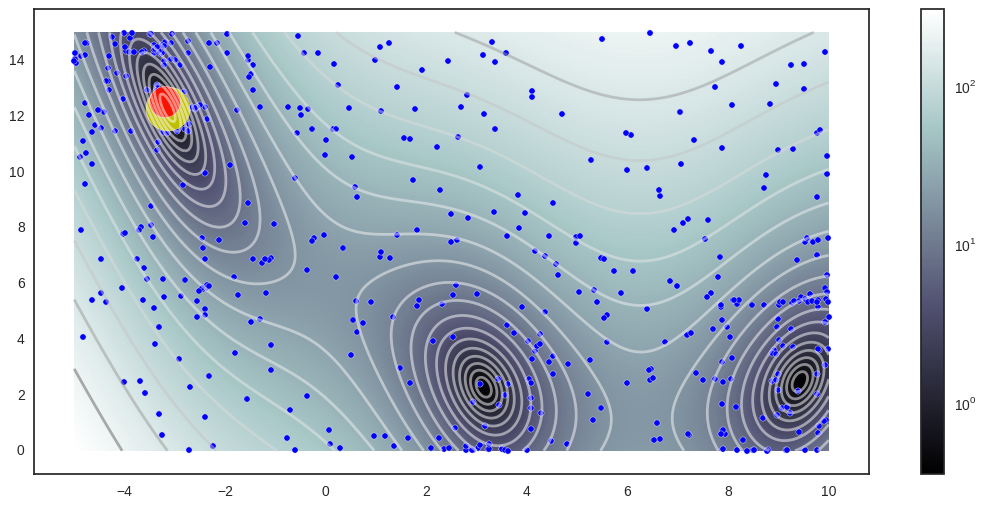

In [23]:
X = np.linspace(rangex1[0], rangex1[1], 500 )
Y = np.linspace(rangex2[0], rangex2[1], 500 )
Z = np.zeros((X.shape[0],Y.shape[0]))
for ix,x in enumerate(X):
    for iy,y in enumerate(Y):
        Z[ix,iy] = branin([x,y])
   
plt.pcolor(X,Y,Z.T,
           norm=LogNorm(vmin=np.min(Z)*0.9,vmax=np.max(Z)),
          cmap='bone')
plt.colorbar()
levels = np.logspace(np.log10(np.min(Z)*0.9), np.log10(np.max(Z)), 20)
plt.contour(Z.T, levels,linewidths=2,alpha=0.5,extent=(-5,10,0,15))
plt.scatter(df['x1'],df['x2'])
plt.scatter(locminZ[0],locminZ[1],s=1000,c='y')
plt.scatter(row['x1'],row['x2'],s=500,c='r',alpha=0.9)

plt.show()


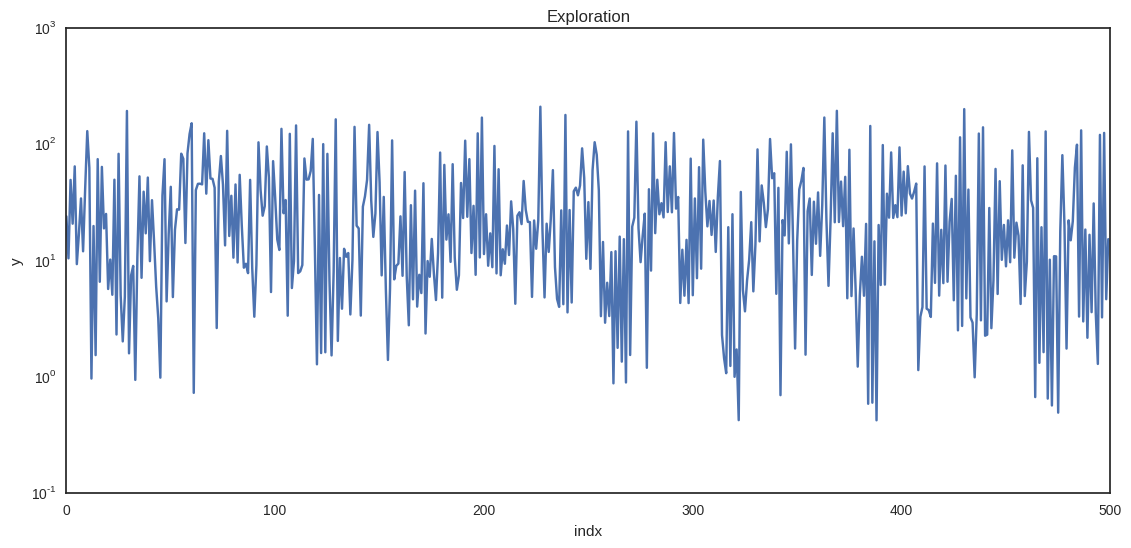

In [22]:
plt.semilogy(df['y'])
plt.xlabel('indx')
plt.ylabel('y')
plt.title('Exploration')
plt.show()

# Categorical

In [50]:
!./smac --scenario-file example_scenarios/branin/branin-scenario-categorical.txt --seed 1234

Picked up JAVA_TOOL_OPTIONS: -javaagent:/usr/share/java/jayatanaag.jar 
[INFO ] Logging to: /home/beangoben/projects/BayesianOpt/smac-v2.10.03-master-778/smac-output/branin-scenario-categorical/log-run1234.txt
[INFO ] Version of SMAC is v2.10.03-master-778 (3ee628ef9bf2), running on OpenJDK 64-Bit Server VM (1.7.0_79) and Linux 3.19.0-28-generic (amd64) 
[INFO ] Call String: smac --scenario-file example_scenarios/branin/branin-scenario-categorical.txt --seed 1234 
[INFO ] Found previous run data in state output folder: /home/beangoben/projects/BayesianOpt/smac-v2.10.03-master-778/smac-output/branin-scenario-categorical , renamed to: old-state-state-run1234-1441812710850
[INFO ] SMAC started at: Sep 9, 2015 11:31:51 AM. Minimizing mean quality.
[INFO ] First incumbent: config 1 (internal ID: 0x000B), with mean quality: 24.129964; estimate based on 1 runs.
[INFO ] Sample call for new incumbent config 1 (internal ID: 0x000B): 
cd /home/beangoben/projects/BayesianOpt/smac-v2.10.03-master-7

In [51]:
run_df = pd.read_csv('smac-output/branin-scenario-categorical/state-run1234/runs_and_results-it10.csv')
param_df = pd.read_csv('smac-output/branin-scenario-categorical/state-run1234/paramstrings-it10.txt',header=0)
extrarow = pd.DataFrame([list(param_df.columns)],columns=list(param_df.columns))
param_df=param_df.set_index(param_df.index+1)
param_df=param_df.append(extrarow)
param_df.sort_index(inplace=True)
param_df.columns = ['x1','x2']
def cleanParamFile(row):

    values = []
    for i in range(row.shape[0]):
        values.append(float(row.iloc[i].split('=')[-1].replace("\'",'')))

    return pd.Series(values)

df = pd.DataFrame(param_df.apply(cleanParamFile,axis=1))
df.columns = ['x1','x2']
df['y']=run_df['Run Quality']
df.head(1)

,x1,x2,y
0,2.5,7.5,24.129964


SMAC: minima 0.695097 at [ 9.3  1.9] 
Opt: minima 0.398056 at [-3.1362725450901805, 12.264529058116231] 


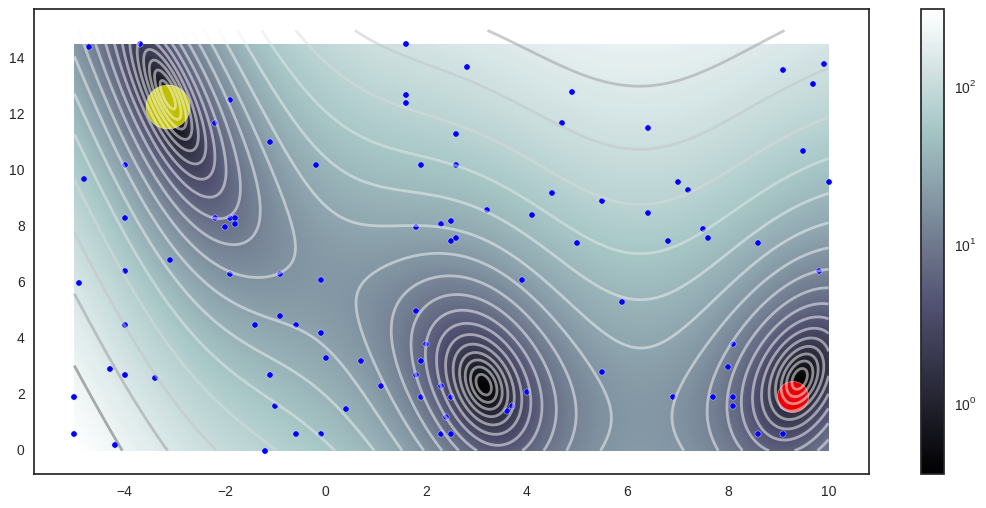

In [52]:
indx =np.argmin(df['y'])
row = df.iloc[indx]
miny=np.min(df['y'])
rangex1=[ np.min(df['x1']),np.max(df['x1'])]
rangex2=[ np.min(df['x2']),np.max(df['x2'])]

print("SMAC: minima %f at %s "%(miny,str(row[['x1','x2']].values)))
print("Opt: minima %f at %s "%(np.min(Z),str(locminZ)))
X = np.linspace(rangex1[0], rangex1[1], 500 )
Y = np.linspace(rangex2[0], rangex2[1], 500 )
Z = np.zeros((X.shape[0],Y.shape[0]))
for ix,x in enumerate(X):
    for iy,y in enumerate(Y):
        Z[ix,iy] = branin([x,y])
   
plt.pcolor(X,Y,Z.T,
           norm=LogNorm(vmin=np.min(Z)*0.9,vmax=np.max(Z)),
          cmap='bone')
plt.colorbar()
levels = np.logspace(np.log10(np.min(Z)*0.9), np.log10(np.max(Z)), 20)
plt.contour(Z.T, levels,linewidths=2,alpha=0.5,extent=(-5,10,0,15))
plt.scatter(df['x1'],df['x2'])
plt.scatter(locminZ[0],locminZ[1],s=1000,c='y')
plt.scatter(row['x1'],row['x2'],s=500,c='r',alpha=0.9)

plt.show()


# Ordinal

In [53]:
!./smac --scenario-file example_scenarios/branin/branin-scenario-ordinal.txt --seed 1234

Picked up JAVA_TOOL_OPTIONS: -javaagent:/usr/share/java/jayatanaag.jar 
[INFO ] Logging to: /home/beangoben/projects/BayesianOpt/smac-v2.10.03-master-778/smac-output/branin-scenario-ordinal/log-run1234.txt
[INFO ] Version of SMAC is v2.10.03-master-778 (3ee628ef9bf2), running on OpenJDK 64-Bit Server VM (1.7.0_79) and Linux 3.19.0-28-generic (amd64) 
[INFO ] Call String: smac --scenario-file example_scenarios/branin/branin-scenario-ordinal.txt --seed 1234 
[INFO ] Found previous run data in state output folder: /home/beangoben/projects/BayesianOpt/smac-v2.10.03-master-778/smac-output/branin-scenario-ordinal , renamed to: old-state-state-run1234-1441812768081
[INFO ] SMAC started at: Sep 9, 2015 11:32:48 AM. Minimizing mean quality.
[INFO ] First incumbent: config 1 (internal ID: 0x000B), with mean quality: 24.129964; estimate based on 1 runs.
[INFO ] Sample call for new incumbent config 1 (internal ID: 0x000B): 
cd /home/beangoben/projects/BayesianOpt/smac-v2.10.03-master-778; example_

In [54]:
run_df = pd.read_csv('smac-output/branin-scenario-categorical/state-run1234/runs_and_results-it10.csv')
param_df = pd.read_csv('smac-output/branin-scenario-categorical/state-run1234/paramstrings-it10.txt',header=0)
extrarow = pd.DataFrame([list(param_df.columns)],columns=list(param_df.columns))
param_df=param_df.set_index(param_df.index+1)
param_df=param_df.append(extrarow)
param_df.sort_index(inplace=True)
param_df.columns = ['x1','x2']
def cleanParamFile(row):

    values = []
    for i in range(row.shape[0]):
        values.append(float(row.iloc[i].split('=')[-1].replace("\'",'')))

    return pd.Series(values)

df = pd.DataFrame(param_df.apply(cleanParamFile,axis=1))
df.columns = ['x1','x2']
df['y']=run_df['Run Quality']
df.head(1)

,x1,x2,y
0,2.5,7.5,24.129964


SMAC: minima 0.695097 at [ 9.3  1.9] 
Opt: minima 0.398016 at [-3.1362725450901805, 12.264529058116231] 


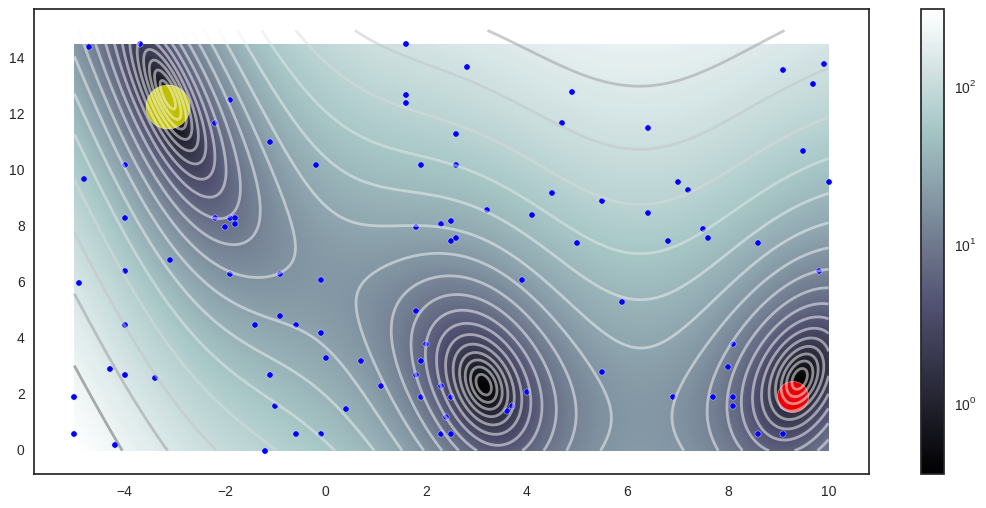

In [55]:
indx =np.argmin(df['y'])
row = df.iloc[indx]
miny=np.min(df['y'])
rangex1=[ np.min(df['x1']),np.max(df['x1'])]
rangex2=[ np.min(df['x2']),np.max(df['x2'])]
print("SMAC: minima %f at %s "%(miny,str(row[['x1','x2']].values)))
print("Opt: minima %f at %s "%(np.min(Z),str(locminZ)))
X = np.linspace(rangex1[0], rangex1[1], 500 )
Y = np.linspace(rangex2[0], rangex2[1], 500 )
Z = np.zeros((X.shape[0],Y.shape[0]))
for ix,x in enumerate(X):
    for iy,y in enumerate(Y):
        Z[ix,iy] = branin([x,y])
   
plt.pcolor(X,Y,Z.T,
           norm=LogNorm(vmin=np.min(Z)*0.9,vmax=np.max(Z)),
          cmap='bone')
plt.colorbar()
levels = np.logspace(np.log10(np.min(Z)*0.9), np.log10(np.max(Z)), 20)
plt.contour(Z.T, levels,linewidths=2,alpha=0.5,extent=(-5,10,0,15))
plt.scatter(df['x1'],df['x2'])
plt.scatter(locminZ[0],locminZ[1],s=1000,c='y')
plt.scatter(row['x1'],row['x2'],s=500,c='r',alpha=0.9)

plt.show()
